## Laboratoria 2.2
## [Zadanie](https://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-kohonen.html)

Do istniejącej implementacji dodać możliwość ułożenia neuronów w topologii siatki sześciokątnej.

Zastosować oba warianty topologii i obie funkcje sąsiedztwa do wektorów danych ze zbiorów
- MNIST
- https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

(sieć Kohonena uruchomić na zbiorach bez etykiet!).

Przeanalizować otrzymane mapowanie danych uwzględniając etykiety danych. Jak dobrze znalezione klastry odpowiadają podziałowi na klasy?

In [1]:
import math
import numpy as np
import pandas as pd
from random import choice
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

In [2]:
class EuclideanDistance:
    @staticmethod
    def distance(x1, x2):
        return np.linalg.norm(x1-x2)
        
class DecayFunction:
    @staticmethod
    def calculate(t, lamb):
        return np.exp(-t/lamb)
    
class Gaussian:
    """
    Neighbourhood function
    """
    @staticmethod
    def calculate(x, t):
        return np.exp(-np.power((x*t), 2))
    
class MexicanHat:
    """
    Minus second derivative of a gaussian
    neighbourhood function
    """
    @staticmethod
    def calculate(x, t):
        return (2-4*np.power(x, 2))*np.exp(-np.power((x*t), 2))

In [3]:
class KohonenNetwork:
    def __init__(self, M: int, N: int, data_dim: int, neigh_width: int, _type: str, dist_class):
        
        # wymiary siatki
        self.M = M
        self.N = N
        # wymiar danych
        self.dim = data_dim
        # szerokość sąsiedztwa
        self.neigh_width = neigh_width
        self.dist_func = dist_class.distance
        
        if _type == 'hexagon':
            x_coord, y_coord = np.meshgrid(range(0,N), range(0,M), sparse=False, indexing='xy')
            # konwersja z int na float pozwoli na przesuwanie 
            # współrzędnych punktów względem OX, OY
            x_coord = x_coord.astype(float)
            
            y_coord = y_coord * np.sqrt(3)/2
            # skaluję współrzędne y (wszystkich) punktów i przesuwam po x 
            # (wybrane) a następnie ponownie przesuwam wszystkie, tym razem 
            # ponownie wszystkie względem OX i OY, żeby nie stworzyć siatki 
            # trójkątów równobocznych tylko sześciokątów
            x_coord[1::2, :] += 0.5 
            x_coord, y_coord = x_coord.reshape(-1,1), y_coord.reshape(-1,1)
            x_coord += 1
            y_coord += 1
            # warunki logiczne, które muszą zostać spełnione, przez 
            # współrzędne punktów (względem współrzędnej x poprzedniego) 
            # aby zadany kształt siatki został uzyskany (dzięki nim 
            # pozbywam się punktów leżących w punkcie symetrii sześciokąta)
            x_coord_prev = x_coord
            x_coord = x_coord[np.logical_not((x_coord_prev%3 == 1)|(x_coord_prev%3 == 2.5))]
            y_coord = y_coord[np.logical_not((x_coord_prev%3 == 1)|(x_coord_prev%3 == 2.5))]
        
            index = [[i,j] for i,j in zip(x_coord, y_coord)]
            self.coords = np.array(index)
            
        else:
            self.coords = np.vstack((np.repeat(np.repeat(np.arange(0,N,1),M), np.tile(np.arange(0,N,1),M))))
        
        self.weights = np.random.uniform(size=(self.coords.shape[0], self.dim))

    def detect_closest_neuron(self, sample: np.array) -> np.array:
        min_dist = np.Inf
        for index in range(self.coords.shape[0]):
            dist = self.dist_func(self.weights[index], sample)
            if dist < min_dist:
                min_dist = dist
                closest_neuron_indexes = index
        return closest_neuron_indexes

   
    def weights_update(self, sample, neigh_func, decay_func, t, lamb):
        closest_neuron = self.detect_closest_neuron(sample)
        for idx in range(self.coords.shape[0]):
            self.weights[idx] += neigh_func(np.linalg.norm(closest_neuron-idx)*self.neigh_width, t) * decay_func(t, lamb) * (sample - self.weights[idx])

    def train(self, train_set, epochs, neigh_func, decay_func):
        for epoch in range(epochs):
            train_set = train_set.sample(frac=1) # shuffle
            for i, row in train_set.iterrows():
                self.weights_update(np.array(row), neigh_func, decay_func, epoch, epochs)
                
    def assign_class(self, X, y):
        """
        Na dany neuron jest mapowanych wiele przykładów 
        uczących - każdy z nich jest ma przypisaną jakąś
        klasę. Aby przypisać klasę do danego neuronu wystarczy
        rozstrzygnąć obserwacji której klasy było dla niego 
        najwięcej i uznać, że ten neuron odpowiada tej klasie        
        """
        k = max(y)+1
        self.classes = np.zeros(shape=(self.coords.shape[0], k))
        for index in range(X.shape[0]):
            point = X.iloc[index, ]
            c = np.array(y)[index]
            min_dist = np.Inf
            argmin = None
            for idx in range(self.coords.shape[0]):
                dist = np.linalg.norm(self.weights[idx] - point)
                if dist < min_dist:
                    min_dist = dist
                    argmin = idx
            self.classes[argmin][c] += 1
            
        neuron_labels = [None for i in range(self.coords.shape[0])]
        for i in range(self.coords.shape[0]):
            neuron_labels[i] = np.argmax(self.classes[i])
        return neuron_labels
    
    def predict(self, X_train, y_train, X_test):
        """
        Zakładając, że do neuronów przypisane zostaną klasy
        na podstawie części treningowej aby dokonać predykcji
        dla nowych obserwacji wystarczy sprawdzić, do którego 
        neuronu z punktu jest najbliżej i nadać punktowi jego 
        klasę.
        """
        self.classes = self.assign_class(X_train, y_train)
        prediction = []
        for index in range(X_test.shape[0]):
            closest_neuron_index = self.detect_closest_neuron(X_test.iloc[index, ])
            prediction.append(self.classes[closest_neuron_index])
        return prediction

## Hexagon 

In [4]:
hexagon = pd.read_csv("../data/mio2/hexagon.csv")
hexagon_train = hexagon[['x', 'y']]

In [5]:
kohonen_network = KohonenNetwork(10, 10, 2, 0.1, 'hexagon', EuclideanDistance)

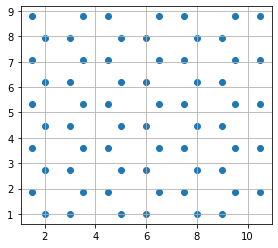

In [6]:
x = list(map(lambda x: x[0], kohonen_network.coords))
y = list(map(lambda x: x[1], kohonen_network.coords))

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x, y)
plt.grid(True)

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(hexagon[['x', 'y']], hexagon.c, test_size=0.3, random_state=42)

In [14]:
kohonen_network.train(X_train, 10, Gaussian.calculate, DecayFunction.calculate)

In [15]:
neuron_classes = kohonen_network.assign_class(X_train, y_train)

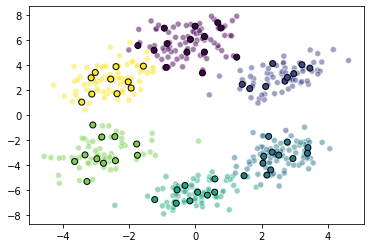

In [16]:
fig = plt.plot(figsize=(20, 6))
plt.scatter(X_train.x, X_train.y, c = y_train, edgecolors='white', alpha=0.5) 
plt.scatter(
        kohonen_network.weights.T[0].reshape(1, -1)[0],
        kohonen_network.weights.T[1].reshape(1, -1)[0],
        c=neuron_classes, edgecolors='black')

In [17]:
prediction = kohonen_network.predict(X_train, y_train, X_test)
round(accuracy_score(y_true=y_test, y_pred=prediction), 4)

0.9833

## MNIST

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state

# Load data from https://www.openml.org/d/554
mnist_data, mnist_labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [7]:
# Data preprocessing
random_state = check_random_state(0)
permutation = random_state.permutation(mnist_data.shape[0])
mnist_data = mnist_data[permutation]
mnist_labels = mnist_labels[permutation]
mnist_data = mnist_data.reshape((mnist_data.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_labels, test_size=0.7)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
y_train, y_test = y_train.astype(int), y_test.astype(int)

Gaussian neighbourhood function and hexagon topology.
Test set score: 0.751600


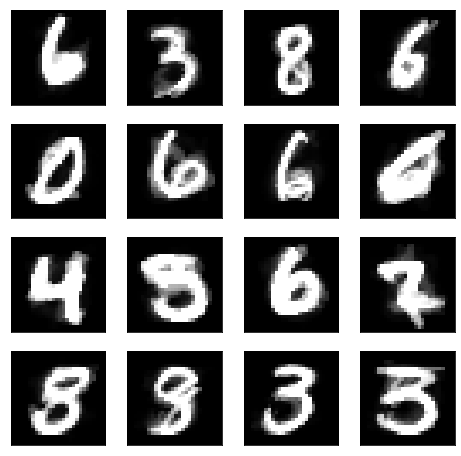

Gaussian neighbourhood function and default topology.
Test set score: 0.881400


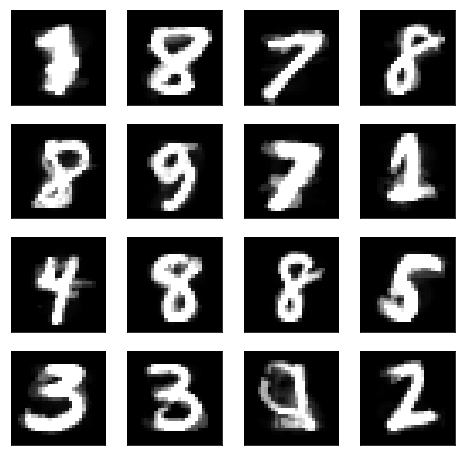

In [8]:
# settings #
topologies = ["hexagon", "default"]
m,n = 10, 10

for topology in topologies:
    # train network
    kohonen_network = KohonenNetwork(m, n, X_train.shape[1], 0.1, topology, EuclideanDistance)
    kohonen_network.train(X_train, 20, Gaussian.calculate, DecayFunction.calculate)
    # perform prediction on test set
    prediction = kohonen_network.predict(X_train, y_train, X_test)
    score = round(accuracy_score(y_true=y_test, y_pred=prediction), 4)
    # score
    print(Gaussian.__name__ + " neighbourhood function and " + topology + " topology.")
    print("Test set score: %f" % score)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    vmin, vmax = kohonen_network.weights.min(), kohonen_network.weights.max()
    for coef, ax in zip(kohonen_network.weights, axes.ravel()):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

MexicanHat neighbourhood function and hexagon topology.
Test set score: 0.464100


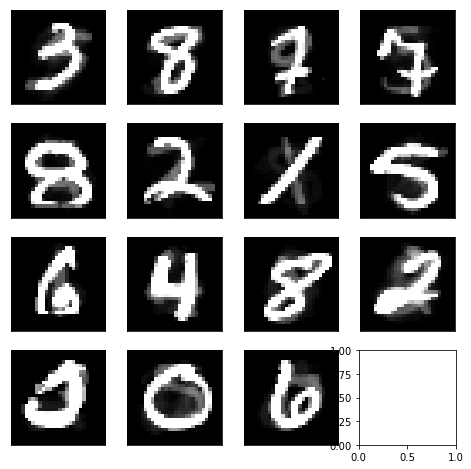

MexicanHat neighbourhood function and default topology.
Test set score: 0.474800


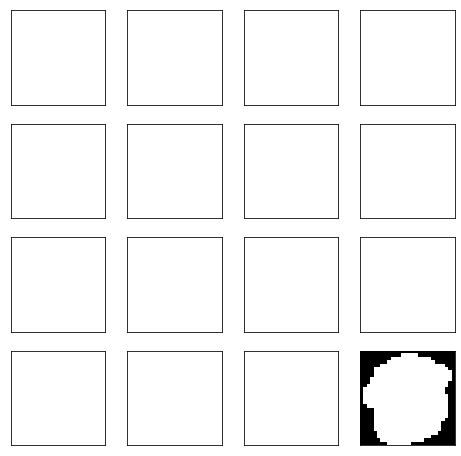

In [22]:
# settings #
topologies = ["hexagon", "default"]
m,n = 5, 5

for topology in topologies:
    # train network
    kohonen_network = KohonenNetwork(m, n, X_train.shape[1], 0.1, topology, EuclideanDistance)
    kohonen_network.train(X_train, 20, MexicanHat.calculate, DecayFunction.calculate)
    # perform prediction on test set
    prediction = kohonen_network.predict(X_train, y_train, X_test)
    score = round(accuracy_score(y_true=y_test, y_pred=prediction), 4)
    # score
    print(MexicanHat.__name__ + " neighbourhood function and " + topology + " topology.")
    print("Test set score: %f" % score)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    vmin, vmax = kohonen_network.weights.min(), kohonen_network.weights.max()
    for coef, ax in zip(kohonen_network.weights, axes.ravel()):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

## Human Activity Recognition Using Smartphones

In [11]:
har_train = pd.read_csv("../data/mio2/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", sep="\s+", header = None)
har_test = pd.read_csv("../data/mio2/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", sep="\s+", header = None)
labels_train = pd.read_csv("../data/mio2/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", sep="\s+", header = None)
labels_test = pd.read_csv("../data/mio2/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", sep="\s+", header = None)
labels_train = np.array(labels_train).reshape(1,-1)[0]
labels_test = np.array(labels_test).reshape(1,-1)[0]

In [14]:
# settings #
topologies = ["hexagon", "default"]
har_gaussian_scores = []
m,n = 10, 10

for topology in topologies:
    # repeat experiments
    for i in range(10):
        # train network
        kohonen_network = KohonenNetwork(m, n, har_train.shape[1], 0.1, topology, EuclideanDistance)
        kohonen_network.train(har_train, 10, Gaussian.calculate, DecayFunction.calculate)
        # perform prediction on test set
        prediction = kohonen_network.predict(har_train, labels_train, har_test)
        # score
        score = round(accuracy_score(y_true=labels_test, y_pred=prediction), 4)
        har_gaussian_scores.append(score)

In [17]:
# settings #
topologies = ["hexagon", "default"]
har_mexican_scores = []
m,n = 10, 10

for topology in topologies:
    # repeat experiments
    for i in range(10):
        # train network
        kohonen_network = KohonenNetwork(m, n, har_train.shape[1], 0.1, topology, EuclideanDistance)
        kohonen_network.train(har_train, 10, MexicanHat.calculate, DecayFunction.calculate)
        # perform prediction on test set
        prediction = kohonen_network.predict(har_train, labels_train, har_test)
        # score
        score = round(accuracy_score(y_true=labels_test, y_pred=prediction), 4)
        har_mexican_scores.append(score)

In [37]:
pd.DataFrame({'Neighbourhood function': ['Gausian', 'Mexican Hat'],
              'Min Accuracy score': [np.min(har_gaussian_scores), np.min(har_mexican_scores)],
              'Mean Accuracy score': [np.mean(har_gaussian_scores), np.mean(har_mexican_scores)],
              'Max Accuracy score': [np.max(har_gaussian_scores), np.max(har_mexican_scores)],
              'Accuracy score std dev': [np.std(har_gaussian_scores), np.std(har_mexican_scores)]})

,Neighbourhood function,Min Accuracy score,Mean Accuracy score,Max Accuracy score,Accuracy score std dev
0,Gausian,0.7788,0.81778,0.8582,0.025485
1,Mexican Hat,0.5840,0.63851,0.7241,0.041311


## Parameterization impact on the classification result  (hexagon dataset)

In [15]:
# Data loading and preprocessing
hexagon = pd.read_csv("../data/mio2/hexagon.csv")
X_train, X_test, y_train, y_test = train_test_split(hexagon[['x', 'y']], hexagon.c, test_size=0.3, random_state=42)

In [16]:
# Universal parameters grids init
m_rng = [5, 10, 15, 20]
n_rng = [4, 6, 8, 10]
width_rng = np.arange(start=0.1, stop=0.5, step=0.1)
topologies = ["hexagon", "default"]

In [17]:
# Gaussian neighbourhood function
gm_col = []
gn_col = []
gtop_col = []
gwidth_col = []
hex_gaussian_scores = []

for topology in topologies:
    for m in m_rng:
        for n in n_rng:
            for width in width_rng:
                kohonen_network = KohonenNetwork(m, n, X_train.shape[1], width, topology, EuclideanDistance)
                kohonen_network.train(X_train, 10, Gaussian.calculate, DecayFunction.calculate)
                prediction = kohonen_network.predict(X_train, y_train, X_test)
                # save params and score
                score = round(accuracy_score(y_true=y_test, y_pred=prediction), 4)
                hex_gaussian_scores.append(score)
                gm_col.append(m)
                gn_col.append(n)
                gtop_col.append(topology)
                gwidth_col.append(width)

In [25]:
params_gaussian = pd.DataFrame({'M': gm_col,
              'N': gn_col,
              'Topology': gtop_col,
              'Neighbourhood width': gwidth_col,
              'Accuracy score': hex_gaussian_scores})
params_gaussian.to_csv('params_gaussian.csv', index=False)

In [23]:
params_gaussian

,M,N,Topology,Neighbourhood width,Accuracy score
0,5,4,hexagon,0.1,0.9833
1,5,4,hexagon,0.2,0.9611
2,5,4,hexagon,0.3,0.9111
3,5,4,hexagon,0.4,0.9667
4,5,6,hexagon,0.1,0.9889
...,...,...,...,...,...
123,20,8,default,0.4,0.9722
124,20,10,default,0.1,0.8556
125,20,10,default,0.2,0.9333
126,20,10,default,0.3,0.9778


In [21]:
# Mexican Hat Neighbourhood function

mm_col = []
mn_col = []
mtop_col = []
mwidth_col = []
hex_mexican_scores = []

for topology in topologies:
    for m in m_rng:
        for n in n_rng:
            for width in width_rng:
                kohonen_network = KohonenNetwork(m, n, X_train.shape[1], width, topology, EuclideanDistance)
                kohonen_network.train(X_train, 10, Gaussian.calculate, DecayFunction.calculate)
                prediction = kohonen_network.predict(X_train, y_train, X_test)
                # save params and score
                score = round(accuracy_score(y_true=y_test, y_pred=prediction), 4)
                hex_mexican_scores.append(score)
                mm_col.append(m)
                mn_col.append(n)
                mtop_col.append(topology)
                mwidth_col.append(width)

In [26]:
params_mexican = pd.DataFrame({'M': mm_col,
              'N': mn_col,
              'Topology': mtop_col,
              'Neighbourhood width': mwidth_col,
              'Accuracy score': hex_mexican_scores})
params_mexican.to_csv('params_mexican', index=False)

In [24]:
params_mexican

,M,N,Topology,Neighbourhood width,Accuracy score
0,5,4,hexagon,0.1,0.9611
1,5,4,hexagon,0.2,0.9333
2,5,4,hexagon,0.3,0.9944
3,5,4,hexagon,0.4,0.9833
4,5,6,hexagon,0.1,0.9722
...,...,...,...,...,...
123,20,8,default,0.4,0.9833
124,20,10,default,0.1,0.8944
125,20,10,default,0.2,0.9722
126,20,10,default,0.3,0.9611
